In [1]:
import sys
sys.path.append('../code')
sys.path.append('../')
import lfp_functions

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import neo
import pandas as pd
from externals.SpectralEvents import spectralevents as se

In [2]:
experiment_dict = sio.loadmat('../data/SPK20220308/task_data/eventsCB1_corrected2.mat')
ev_ex = experiment_dict['eventsCB1']

downsample_rate = 30
samp_freq = 1000

#Use neo module to load blackrock files
fpath = '../data/SPK20220308/task_data/SPKRH20220308_CB1_quiver4toyPKPK4Rotation_delay_001'
lfp_data_raw, lfp_times_raw = lfp_functions.load_ns6_analog(fpath, downsample_rate, from_ns6=False, save=False, channel_step=2)

In [10]:
tgtON = ev_ex['tgtON_C'][0][0][0]
gocON = ev_ex['gocON_C'][0][0][0]
stmv = ev_ex['stmv_C'][0][0][0]
endhold = ev_ex['endhold_C'][0][0][0]

st_offset = -1 # seconds
max_time = 2 # seconds
max_samples = int(max_time * samp_freq)
channel_idx = 50

event_ts = gocON
lfp_data_list = list()
for event_time in event_ts:
    tstart = event_time + st_offset
    start_idx = np.argmin(np.abs(lfp_times_raw - tstart))
    stop_idx = start_idx + max_samples

    lfp_data_list.append(lfp_data_raw[channel_idx, start_idx:stop_idx])

lfp_data = np.stack(lfp_data_list)


In [11]:
# set parameters
freqs = list(range(1, 60 + 1))   # fequency values (Hz) over which to calculate TFR
#times = np.arange(n_times) / samp_freq  # seconds
event_band = [13, 29]  # beta band (Hz)
thresh_FOM = 6.0  # factor-of-the-median threshold



In [12]:
times = np.linspace(0, lfp_data.shape[1] / samp_freq, lfp_data.shape[1])
tfrs = se.tfr(lfp_data[:,:], freqs, samp_freq)


In [13]:
#tfrs = se.tfr(z, freqs, samp_freq)


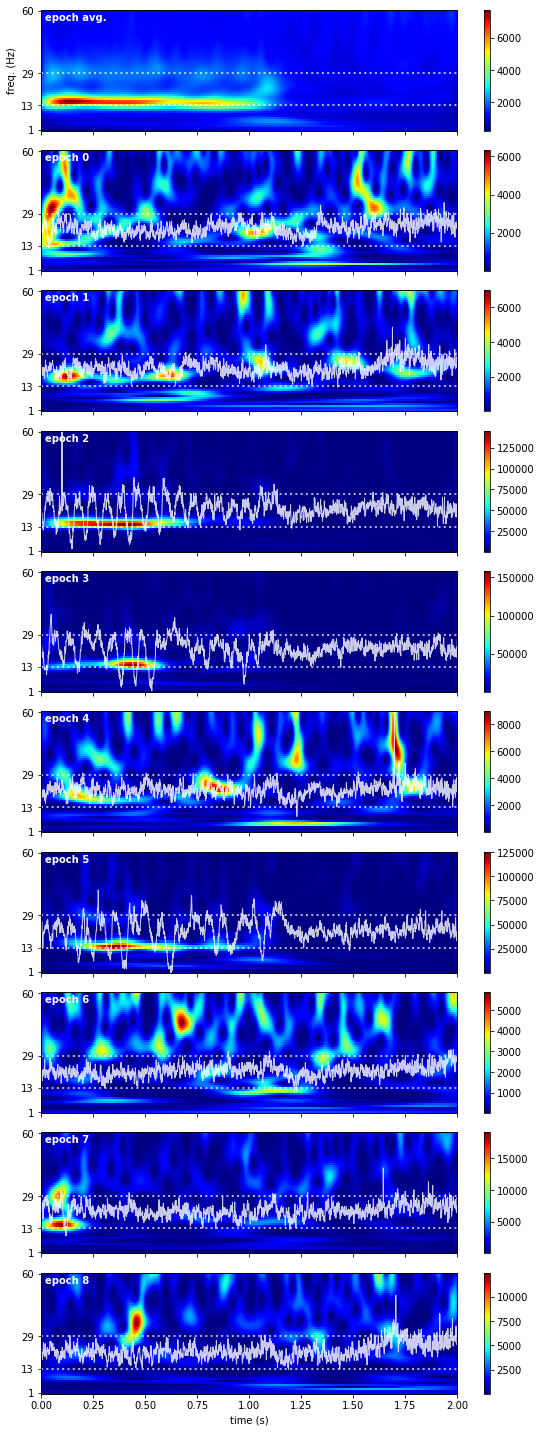

In [15]:
example_trials = [0,1,2,3,4,5,6,7,8]
#vlim = [0, 7.5e-17]

fig = se.plot_avg_spectrogram(tfr=tfrs,
                              times=times,
                              freqs=freqs,
                              event_band=event_band,
                              timeseries=lfp_data,
                              example_epochs=example_trials,
                              figsize=(8,20))

In [16]:
spec_events = se.find_events(tfr=tfrs, times=times, freqs=freqs,
                             event_band=event_band, threshold_FOM=thresh_FOM)

In [31]:
event_df_list = list()
for trial_idx, trial_events in enumerate(spec_events):
    for event_idx, event_dict in enumerate(trial_events):
        event_dict['Trial'] = trial_idx
        event_df_list.append(event_dict)




In [33]:
event_df = pd.DataFrame(event_df_list)

In [41]:
max_event_df = event_df.groupby('Trial').max('Normalized Peak Power').reset_index()

In [60]:
for row_idx, row in max_event_df.iterrows():
    trial_idx = row['Trial'].astype(int)
    peak_time = row['Peak Time']
    print(trial_idx, end=' ')

0 1 2 3 4 5 7 8 9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25 26 27 28 30 32 33 34 36 37 38 39 40 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 65 66 68 69 70 71 72 73 74 75 76 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 101 102 103 104 106 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 151 152 153 154 156 158 159 160 161 162 166 167 168 169 171 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 190 191 192 193 194 195 196 197 198 199 202 203 204 205 206 207 208 209 210 211 212 214 215 217 